# SDOF system with energy dissipation based upon snap-back mechanisms

In [2]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

In [3]:
def model(z , t , M , C , K , f_0 , ome):
    """
    z would be the solution vector
    dzdt stores the system of ODEs ready for integration.
    """
    U = z[0]
    V = z[1]
    f_t  = force(f_0 , ome , t)
    dUdt = V
    dVdt = (1/M)*(f_t - C*V - K*U)
    dzdt = [dUdt , dVdt]
    
    return dzdt

In [4]:
def force(f_0 , ome , t):
    """
    
    """
    f_t = f_0*np.sin(ome*t)
    return f_t

In [5]:
def misses(F_0 , fac , lmda , x):
    """
    Constitutive law for the Misses truss, This is piecewise
    continuous function.
    F_0 : force amplitude
    fac : number of wavelengths at which the constant slope phase starts
    lmda: Wavelength
    x   : Displacement
    """
    dx = lmda/100
    df = F_0*np.sin((2*np.pi/lmda)*dx)
    k = df/dx
    if x > -fac*lmda and x < fac*lmda:
        F = F_0*np.sin((2*np.pi/lmda)*x)
    else:
        if x<= -fac*lmda:
            F = k*(x + fac*lmda)
        else:
            F = k*(x - fac*lmda)
    return F

In [6]:
def dissip_device(z , t , M , C , K , f_0 , ome , m , c , k , F_0 , fac , lmda):
    """
    z would be the solution vector
    dzdt stores the system of ODEs ready for integration.
    """
    U = z[0]
    V = z[1]
    u = z[2]
    v = z[3]
#
    F_AP  = force(f_0 , ome , t)
    F_VM  = misses(F_0 , fac , lmda ,U-u)
#
    dUdt = V
    dVdt = (1/M)*(F_AP - C*V - K*U-F_VM)
    dudt = v
    dvdt = (1/m)*(F_VM - k*u - c*v)
#
    dzdt = [dUdt , dVdt , dudt , dvdt]
    
    return dzdt

## (1)-Simple sdof oscillator

Consider the following oscillator

$$M\ddot U(t)+C\dot U(t)+KU(t)=F_0S_{\omega t}$$

Performing the change of variables we convert the 2-nd order ODE into a system of first order ODEs:

$$\dot U(t)= V(t)$$

$$\dot V(t)=\frac1M \lbrack F_0S_{\omega t}-CV(t)-KU(t)\rbrack .$$

<IPython.core.display.Javascript object>


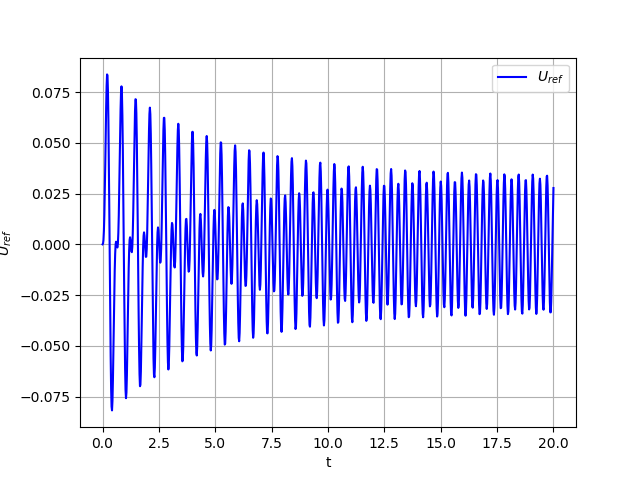

In [19]:
# System parameters
M   = 1.0                        #Building mass
C   = 0.4                        #Building dashpot coefficient
K   = 100.0                       #Building stiffness
f_0 = 10.0                       #Building amplitude of the applied force
ome = 20.0                     #Frequency of applied force
#
y0 = [0.0 , 0.0]                 # Initial conditions
t  = np.linspace(0 , 20 , 1001)    #Time span
#
#------Integrate---------
#
sol  = odeint(model , y0 , t , args=(M , C , K , f_0 , ome))
#
#------Plot---------
#
plt.figure(0)
U_ref = sol[:, 0]
plt.plot(t, U_ref , 'b', label='$U_{ref}$')
plt.legend(loc='best')
#plt.axis([0 , 20.0 , -0.1 , 0.1])
plt.ylabel('$U_{ref}$')
plt.xlabel('t')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


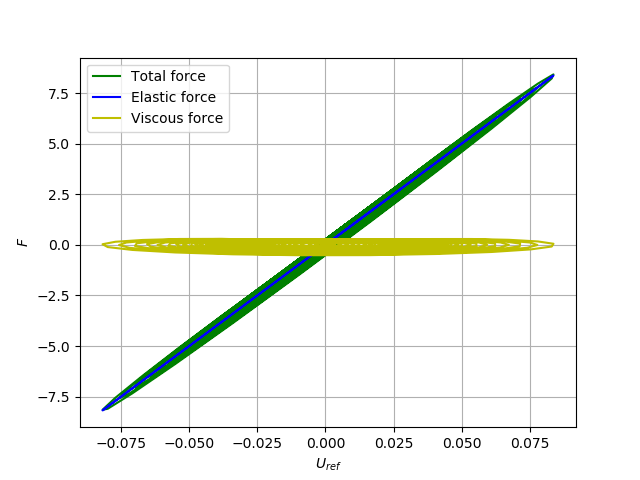

In [20]:
plt.figure(1)
V_ref = sol[: , 1]
F_r = K*U_ref + C*V_ref
plt.plot(U_ref , F_r , 'g', label='Total force')
F_s = K*U_ref 
plt.plot(U_ref , F_s , 'b', label='Elastic force')
F_v = C*V_ref 
plt.plot(U_ref , F_v , 'y', label='Viscous force')
plt.legend(loc='best')
plt.xlabel('$U_{ref}$')
plt.ylabel('$F$')
plt.grid()
plt.show()

##  (2) The Misses truss

Let us test the response in the truss

In [29]:
#
# Misses truss parameters
#
F_0   = 0.16    #Force amplitude for the Misses truss
fac   = 1.0    #Piecewise continous at fac*lambda
lmda  = 0.1   #Wavelength for the Misses truss F-d relationship
#
x  = np.linspace(-2*lmda , 2*lmda, 1001) #Assumed displacements span
n = len(x)
FM = np.zeros(n)
#
for i in range(n):
    FM[i] = misses(F_0 , fac , lmda , x[i])

<IPython.core.display.Javascript object>


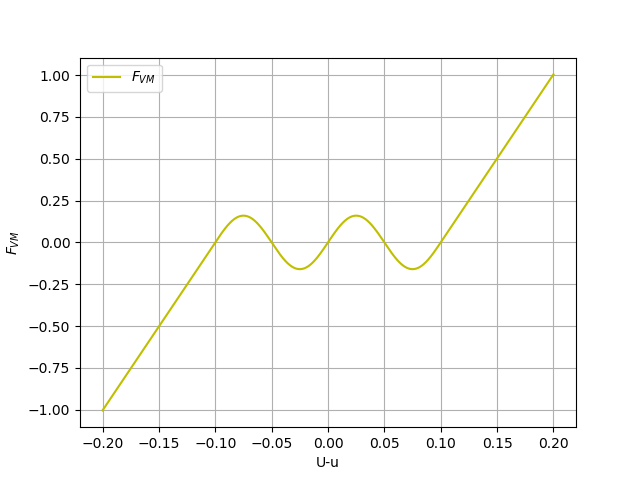

In [30]:
plt.figure(2)
plt.plot(x , FM , 'y', label='$F_{VM}$')
plt.legend(loc='best')
plt.xlabel('U-u')
plt.ylabel('$F_{VM}$')
plt.grid()
plt.show()

## (3) System with added device

<center><img src="img/sdof.png" alt="Picture1.png" style="width:400px"></center>

The dissipation device corresponds to a Misses truss with a spring of stiffness $k_{VM}$

<center><img src="img/truss.png" alt="Picture1.png" style="width:200px"></center>

For the oscillator:

$$M_B\ddot{U\;}+C\dot U\;+K_BU+F_{VM}(U-u)=f(t)$$

for the device:

$$m\ddot u\;+\widehat c\dot u\;+k_{VM}u-F_{VM}(U-u)=0$$

In [31]:
y0 = [0.0 , 0.0 , 0.0 , 0.0]
#
# System parameters
#
M_B = M
K_B = 50.0
C_B = 0.2
#
# Device parameters
#
m   = 1.0e-3  #Device fictitious mass
c   = 0.2     #Device inherent dampong
pf  = 0.16
k   = pf*K    #Spring in the Misses truss
#
#------Integrate---------
#
sol  = odeint(dissip_device , y0 , t ,  args =(M_B , C_B , K_B , f_0 , ome , m , c , k , F_0 , fac , lmda))

<IPython.core.display.Javascript object>


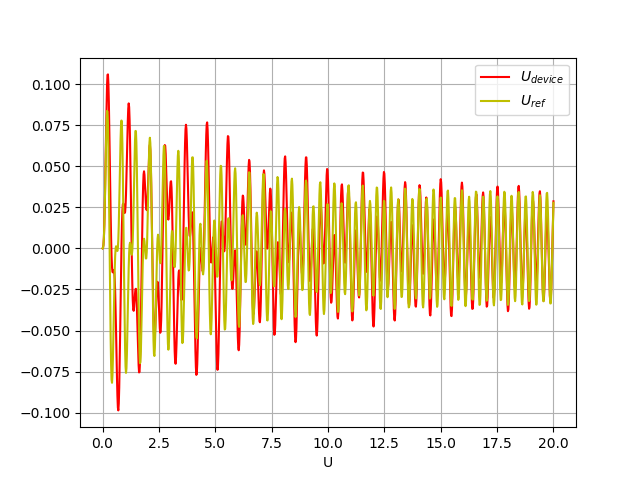

In [32]:
plt.figure(5)
U_dev = sol[:, 0]
plt.plot(t, U_dev , 'r', label='$U_{device}$')
plt.plot(t, U_ref , 'y', label='$U_{ref}$')
#plt.plot(t, U_nodev , 'b', label='$U_{nodev}$')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlabel('U')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


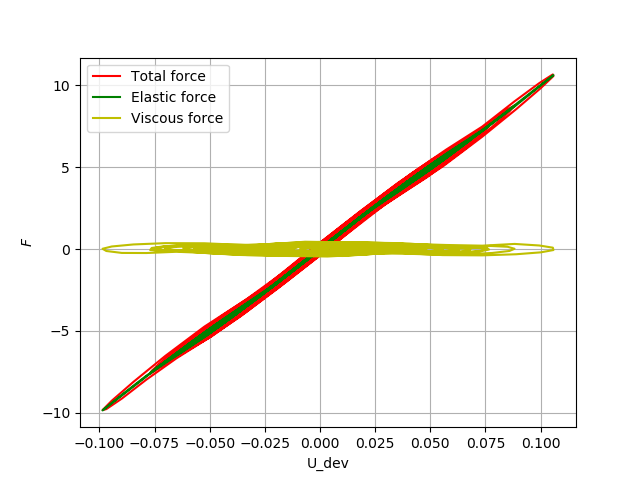

In [33]:
plt.figure(6)
V_dev = sol[: , 1]
u_dev = sol[: , 2]
v_dev = sol[: , 3]
F_r = K*U_dev + C*V_dev + k*u_dev + c*v_dev
plt.plot(U_dev , F_r , 'r', label='Total force')
F_s = K*U_dev + k*u_dev
plt.plot(U_dev , F_s , 'g', label='Elastic force')
F_v = C*V_dev + c*v_dev
plt.plot(U_dev , F_v , 'y', label='Viscous force')
plt.legend(loc='best')
plt.xlabel('U_dev')
plt.ylabel('$F$')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


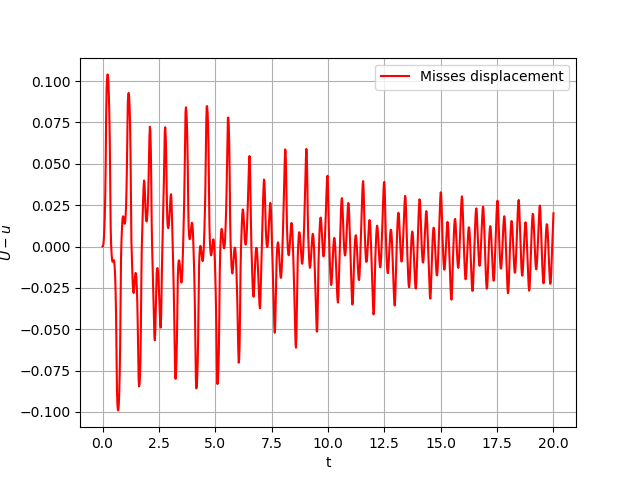

In [34]:
plt.figure(7)
plt.plot(t , U_dev-u_dev , 'r', label='Misses displacement')

plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('$U-u$')
plt.grid()
plt.show()

### Response of the Misses truss

In [35]:
#
# Misses truss parameters
#
F_0   = 10.0    #Force amplitude for the Misses truss
fac   = 1.0     #Piecewise continous at fac*lambda
lmda  = 0.5     #Wavelength for the Misses truss F-d relationship
#
n = 1001
FM = np.zeros(n)
#
for i in range(n):
    FM[i] = misses(F_0 , fac , lmda , sol[i, 0]-sol[i, 2])

<IPython.core.display.Javascript object>


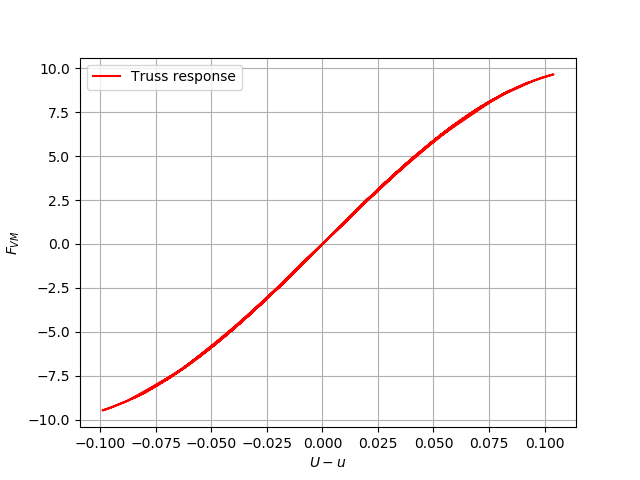

In [36]:
plt.figure(8)
plt.plot(U_dev-u_dev , FM , 'r', label='Truss response')

plt.legend(loc='best')
plt.xlabel('$U-u$')
plt.ylabel('$F_{VM}$')
plt.grid()
plt.show()

In [27]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()